# Quadrotor Model

Multirotors are underactuated aerial robots that consist of multiple motor/propeller combinations. A quadrotor has four motor/propellor combinations, as shown in the below figure.

Figure

## Coordinate Frames

Coordinate frames are rigid, orthonormal bases of $\mathbb{R}^3$. There are two main coordinate frames of interest: the inertial frame $\mathcal{F}^i$ and the body frame $\mathcal{F}^b$. The inertial frame $\mathcal{F}^i$ is an orthonormal basis of $\mathbb{R}^3$ that is earth-fixed and defined as the ''home'' position. The body frame $\mathcal{F}^b$ represents the quadrotor and we assume that its origin is the center of mass of the quadrotor. 

Intermediate frames exist that help us account for the roll, pitch, and yaw rotations of the quadrotor. The first intermediate frame is the vehicle frame $\mathcal{F}^v$, which is at the position of the unrolled, unpitched, unyawed quadrotor. The vehicle frame leads to the vehicle-1 frame $\mathcal{F}^{v1}$ by yawing about the $\mathbf{k}^v$ axis, resulting in the unrolled, unpitched frame. Pitching about the new $\mathbf{j}^{v1}$ axis results in the unrolled vehicle-2 frame $\mathcal{F}^{v2}$, and rolling about the new $\mathbf{i}^{v2}$ axis results in the properly oriented body frame $\mathcal{F}^b$.

Additional frames may be the camera frame, the gimbal frame, or other sensor or measurement frames.

Note that in this work, we use the aerospace standard of passive, right-handed rotations and we will use 3-2-1 ($\psi$-$\theta$-$\phi$) Euler angles for yaw, pitch, roll, respectively.

Python code that builds proper rotation matrices in $\mathbb{R}^{3\times3}$ is given below. These rotation matrices can be used to rotate from the vehicle (or inertial) frame to the body frame through all the intermediate frames.

In [1]:
import numpy as np

def Rot_v_to_v1(psi):
    R = np.array([
        [ np.cos(psi), np.sin(psi), 0],
        [-np.sin(psi), np.cos(psi), 0],
        [     0,           0    ,   1]
    ])
    return R

def Rot_v1_to_v2(theta):
    R = np.array([
        [np.cos(theta), 0, -np.sin(theta)],
        [      0      , 1,        0      ],
        [np.sin(theta), 0,  np.cos(theta)]
    ])
    return R

def Rot_v2_to_b(phi):
    R = np.array([
        [1,       0,           0     ],
        [0,  np.cos(phi), np.sin(phi)],
        [0, -np.sin(phi), np.cos(phi)]
    ])
    return R

def Rot_v_to_b(phi, theta, psi):
    return Rot_v2_to_b(phi).dot(Rot_v1_to_v2(theta).dot(Rot_v_to_v1(psi)))

def Rot_i_to_b(phi, theta, psi):
    return Rot_v_to_b(phi, theta, psi)

## Configuration Space

The quadrotor equations of motion consist of $6$ degrees of freedom (DOF) and $12$ ordinary differential equations ($6$ are kinematic and $6$ are dynamic). The quadrotor is modelled as a freely-rotating rigid body evolving in $\mathcal{M} = \mathbb{R}^3 \times \text{SO}(3)$.

Note that $\text{SO}(3)$ is a matrix Lie group that describes the orientation of rigid body in 3D space and is not isomorphic to $\mathbb{R}^3$. However, because Lie groups are smooth (i.e., differentiable) manifolds, there is an atlas of charts (i.e., homemorphisms) that allow the manifold to be locally described as a Euclidean space. A popular set of local parameterizations are the intuitive Euler angles, of which there are twelve. We will use the 3-2-1 ($\psi$-$\theta$-$\phi$) Euler angle representation as is common in aerospace with first a yaw rotation about $\mathbf{k}$, a pitch rotation about $\mathbf{j}$, and then a roll rotation about $\mathbf{i}$. Additionally, we assume that the roll, pitch, and yaw of the quadrotor are small -- a logical assumption for the smooth trajectories of typical maneuvers. More precisely, we have that
$$
\phi \in [0, 2\pi) \subset \mathbb{R} \\
\theta \in (-\pi/2, \pi/2) \subset \mathbb{R} \\
\psi \in [0, 2\pi) \subset \mathbb{R}.
$$
Thus, the state of the quadrotor is given by $\mathbf{x} = \begin{bmatrix} x & y & z & \phi & \theta & \psi \end{bmatrix}^\top \in \mathbb{R}^6$.

## Numerical Integration

Before our discussion of the dynamical equations of motion that describe the time evolution of the quadrotor in $\text{SE}(3)$, we should discuss how to properly integrate these differential equations numerically for use in a simulation. The two most common types of numerical integrators are Euler's method and the fourth order Runge-Kutta method, or RK4.

### The Euler Method

The Euler method is an explicit algorithm that uses the limit definition of the derivative:
$$
\frac{df}{dt} = \lim_{h\to0} \frac{f(t + h) - f(t)}{h}.
$$
Let $g(t) \triangleq \frac{df}{dt}(t)$. Disregarding the limit and rearranging the difference quotient yields
$$
f(t+h) = f(t) + g(t)h.
$$
Using the step size $h$ as the sample period and using discrete notation, we have
$$
f[k+1] = f[k] + g[k] T_s.
$$

### RK4

Of course, the Euler Method is a first-order, rough approximation of differential equations. Given a differential equation $\dot{y} = f(t,y)$, the RK4 method is given by
$$
\begin{align}
y_{n+1}	&=	y_{n}+\frac{h}{6}\left(k_{1}+2k_{2}+2k_{3}+k4\right) \\
t_{n+1}	&=	t_{n}+h,
 \end{align}
$$

where
$$
\begin{align}
k_{1} &= f\left(t_{n},y_{n}\right) \\
k_{2} &= f\left(t_{n}+\frac{h}{2},y_{n}+\frac{h}{2}k_{1}\right) \\
k_{3} &= f\left(t_{n}+\frac{h}{2},y_{n}+\frac{h}{2}k_{2}\right) \\
k_{4} &= f\left(t_{n}+h,y_{n}+hk_{3}\right).
\end{align}
$$

In [2]:
def rk4(f, y, dt):
    """Runge-Kutta 4th Order
    
    Solves an autonomous (time-invariant) differential equation of the form dy/dt = f(y).
    """
    k1 = f(y)
    k2 = f(y + dt/2*k1)
    k3 = f(y + dt/2*k2)
    k4 = f(y + dt  *k3)
    return y + (dt/6)*(k1 + 2*k2 + 2*k3 + k4)

#### RK4 Example

Consider the autonomous evolution of position $x \in \mathbb{R}$ as
$$
\dot{x} = \cos(\omega(t))
$$

where
$$
\omega(t) =
\begin{cases}
    2 \pi t, & 0 < t < 2.5 \\
    4 \pi t, & 2.5 \leq t < 5 \\
\end{cases}.
$$

Note that this equation is not smooth (there is a jump at $t = 2.5$), but we are still able to numerically integrate it.

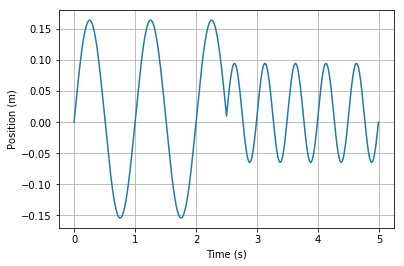

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# simulation timing
Tf = 5
Ts = 0.01
N = int(Tf/Ts)

# initital condition
x = 0

# simulation history
x_hist = np.zeros((N,1))

for i in range(N-1):
    # dynamics
    freq = 1 if i < N//2 else 2
    v = np.cos(2*np.pi*freq*(Ts*i))
    f = lambda x: v

    # propagate dynamics by solving the differential equation
    x = rk4(f, x, Ts)
    
    # add to history
    x_hist[i+1] = x
    
plt.plot(np.arange(0, Tf, Ts), x_hist)
plt.grid(); plt.xlabel('Time (s)'); plt.ylabel('Position (m)')
plt.show()

### Lie Group Integration

Note that the above formulations we assume Euclidean spaces instead of matrix Lie groups.

## Equations of Motion

### Kinematics

Kinematics describe the motion of an object without consideration of what caused that motion. Using kinematics, we can relate position to velocity and orientation to angular velocity. Notice that these equations are irrespective of intertial properties such mass and size.

#### Translational

$$
\dot{\mathbf{r}}^i = R_b^i \mathbf{v}^b
$$

#### Rotational

When determining the rotational kinematic equation of a rigid body, we are asking how the angular velocities relate to the current orientation. A rate gyroscope is used to measure the angular velocity about each of the body-frame axes of the rigid body. These gyro measurements are given by $\mathbf{\omega}^b = p\mathbf{i}^b + q\mathbf{j}^b + r\mathbf{k}^b = \begin{bmatrix} p & q & r\end{bmatrix}^\top$.

Difficulty relating $\mathbf{\omega}$ with the orientation expressed with Euler angles arises because each Euler angle is defined in a different frame. Therefore, the derivatives of each Euler angle must be transformed into the proper frame as follows:

$$
\begin{align}
\mathbf{\omega} =
  \begin{bmatrix} p \\ q \\ r \end{bmatrix} &= 
  \begin{bmatrix} \dot{\phi} \\ 0 \\ 0 \end{bmatrix} +
  R_{v2}^b(\phi) \begin{bmatrix} 0 \\ \dot{\theta} \\ 0 \end{bmatrix} +
  R_{v2}^b(\phi) R_{v1}^{v2}(\theta) \begin{bmatrix} 0 \\ 0 \\ \dot{\psi} \end{bmatrix} \\
&=
  \begin{bmatrix} \dot{\phi} \\ 0 \\ 0 \end{bmatrix} +
  \begin{bmatrix}
    1 & 0 & 0 \\
    0 & \cos\phi & \sin\phi \\
    0 & -\sin\phi & \cos\phi
  \end{bmatrix}
  \begin{bmatrix} 0 \\ \dot{\theta} \\ 0 \end{bmatrix} +
  \begin{bmatrix}
    1 & 0 & 0 \\
    0 & \cos\phi & \sin\phi \\
    0 & -\sin\phi & \cos\phi
  \end{bmatrix}
  \begin{bmatrix}
    \cos\theta & 0 & -\sin\theta \\
    0 & 1 & 0 \\
    \sin\theta & 0 & \cos\theta
  \end{bmatrix}
  \begin{bmatrix} 0 \\ 0 \\ \dot{\psi} \end{bmatrix} \\
&=
\underbrace{
  \begin{bmatrix}
    1 & 0 & -\sin\theta \\
    0 & \cos\phi & \sin\phi\cos\theta \\
    0 & -\sin\phi & \cos\phi\cos\theta
  \end{bmatrix}
}_{\Gamma^{-1}}
  \begin{bmatrix} \dot\phi \\ \dot\theta \\ \dot\psi \end{bmatrix}.
\end{align}
$$

Note that $\det\Gamma^{-1} = cos\theta$. Thus, for $\theta \in (-\pi/2, \pi/2)$ the matrix $\Gamma^{-1}$ is invertible, and we can write the rotational kinematic equation using Euler angles as

$$
\mathbf{\dot\Phi} =
\begin{bmatrix} \dot\phi \\ \dot\theta \\ \dot\psi \end{bmatrix} =
\begin{bmatrix}
  1 & \sin\phi\tan\theta & \cos\phi\tan\theta \\
  0 & \cos\phi & -\sin\phi \\
  0 & \sin\phi\sec\theta & \cos\phi\sec\theta
\end{bmatrix}
\begin{bmatrix} p \\ q \\ r \end{bmatrix} =
\Gamma(\phi,\theta) \mathbf{\omega}.
$$

### Dynamics

Dynamics describe the motion of objects in relation to forces and torques, which cause motion. This is often how we use a controller to interact with a physical system. This is because we can control actuators which cause a force or torque on the system.

#### Translational

It is easiest to express Newton's second law in the body frame. However, Newton's laws only hold in inertial frames. Therefore, we use the equation of Coriolis to express the derivative of an inertial frame quantity to the derivative in the body frame, which gives us

$$
\mathbf{F}_g - \mathbf{T} = m\dot{\mathbf{v}}^b + \mathbf{\omega} \times \mathbf{v}^b,
$$

where $\mathbf{F}_g = mg \begin{bmatrix} -\sin\theta & \cos\theta\sin\phi & \cos\theta\cos\phi \end{bmatrix}^\top$ and $\mathbf{T} = \begin{bmatrix} 0 & 0 & f \end{bmatrix}^\top$. This can be rearranged into

$$
\dot{\mathbf{v}}^b = \frac{1}{m}[\mathbf{F}_g - \mathbf{T} - \mathbf{\omega} \times \mathbf{v}^b].
$$

#### Translational (inertial)

Alternatively, we can express the translational dynamics in the inertial frame, which can be advantageous if we are trying to command inertial positions or velocities.

$$
m\ddot{\mathbf{r}}^i = mg\mathbf{k}^i - R_b^i \begin{bmatrix} 0 \\ 0 \\ u_1 \end{bmatrix}
$$

#### Rotational

Following Netwton's second law for rotational motion ($M = I\dot\omega$), we get

$$
I\mathbf{\dot\omega} = -\omega \times I\omega + M.
$$

We assume that the quadrotor is symmetric about its axes so that
$$
I=
\begin{bmatrix}
    I_x &  0  &  0  \\
     0  & I_y &  0  \\
     0  &  0  & I_z \\
\end{bmatrix}
$$

## Forces and Moments

Given that we have a dynamic model of a quadrotor, we must determine the forces and moments that are used to drive the 6 DOF dynamic model we have derived.

$$
\begin{bmatrix} u_1 \\ u_2 \\ u_3 \\ u_4 \end{bmatrix} =
\begin{bmatrix}
    1 & 1 & 1 & 1 \\
    0 & -\ell & 0 & \ell \\
    \ell & 0 & -\ell & 0 \\
    -c_T & c_T & -c_T & c_T \\
\end{bmatrix}
\begin{bmatrix} T_1 \\ T_2 \\ T_3 \\ T_4 \end{bmatrix}
$$

The thrust $T_i$ produced by each motor/propellor combination is related to the propellor's angular velocity by
$$
T_i = k\Omega_i^2.
$$

Using these expressions, we can find the actual motor commands.

Note: Given that the thrust is such that it is always overcoming gravity, a positive $m_\phi$ yields a positive motion along $\mathbf{j}^b$. A positive $m_\theta$ yields a negative motion along $\mathbf{i}^b$.

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

class Quadrotor(object):
    """Quadrotor
        
    This class models the physical quadrotor vehicle evolving in SE(3).
    """
    def __init__(self, r=None, Phi=None, v=None, omega=None):
        
        # internal quadrotor state
        self.r = r if r is not None else np.zeros((3,1))
        self.Phi = Phi if Phi is not None else np.zeros((3,1))
        self.v = v if v is not None else np.zeros((3,1))
        self.omega = omega if omega is not None else np.zeros((3,1))
        
        # phyiscal true parameters
        self.g = 9.81
        self.mass = 1
        self.I = np.array([[1,0,0],
                           [0,1,0],
                           [0,0,1]])
        
        # convenience
        self.Niters = 0
        
    def __str__(self):
        s  = "Quadrotor state after {} iters:\n".format(self.Niters)
        s += "\tr:     {}.T\n".format(self.r.T)
        s += "\tPhi:   {}.T\n".format(self.Phi.T)
        s += "\tv:     {}.T\n".format(self.v.T)
        s += "\tomega: {}.T\n".format(self.omega.T)
        return s

    @staticmethod
    def Gamma(phi, theta):
        return np.array([
            [1, np.sin(phi)*np.tan(theta), np.cos(phi)*np.tan(theta)],
            [0,         np.cos(phi)      ,        -np.sin(phi)      ],
            [0, np.sin(phi)/np.cos(theta), np.cos(phi)/np.cos(theta)]
        ])
        
    def Fg(self, phi, theta):
        return self.mass*self.g*np.array([[      -np.sin(theta)     ],
                                          [np.cos(theta)*np.sin(phi)],
                                          [np.cos(theta)*np.cos(phi)]])
    
    def update(self, u, dt):
        # We've been through another iteration
        self.Niters += 1
        
        # Extract Euler angles for convenience
        ph = self.Phi.flatten()[0]
        th = self.Phi.flatten()[1]
        ps = self.Phi.flatten()[2]
        
        #
        # Forces and Moments
        #
        
        u = np.array(u).flatten()
        T = np.array([[0, 0, u[0]]]).T
        M = np.array([[u[1], u[2], u[3]]]).T
        
        #
        # Kinematics
        #
        
        # Translational
#         f = lambda r: Rot_i_to_b(ph,th,ps).T.dot(self.v) # body velocities
        f = lambda r: self.v # inertial velocities
        self.r = rk4(f, self.r, dt)
        
        # Rotational
        f = lambda Phi: self.Gamma(Phi[0], Phi[1]).dot(self.omega)
        self.Phi = rk4(f, self.Phi, dt)
        
        #
        # Dynamics
        #
        
        # Translational
#         f = lambda v: (1/self.mass)*(self.Fg(ph,th) - T - np.cross(self.omega, v, axis=0)) # body
        f = lambda v: (1/self.mass)*(self.Fg(0,0) - Rot_i_to_b(ph,th,ps).T.dot(T)) # inertial
        self.v = rk4(f, self.v, dt)
        
        # Rotational
        f = lambda omega: np.linalg.inv(self.I).dot((-np.cross(omega, self.I.dot(omega), axis=0) + M))
        self.omega = rk4(f, self.omega, dt)

In [5]:
quad = Quadrotor()

Ts = 0.01
Tf = 1.5
N = int(Tf/Ts)
for i in range(N):
    m1 = 10 if Ts*i < 1 else 0
    quad.update([20, 0.1, 0.1, 0], Ts)
print(quad)

Quadrotor state after 150 iters:
	r:     [[-0.405  0.405 -11.369]].T
	Phi:   [[ 0.112  0.112  0.006]].T
	v:     [[-1.101  1.101 -15.212]].T
	omega: [[ 0.150  0.150  0.000]].T



## References

[1] R. W. Beard and T. W. McLain, Small Unmanned Aircraft. Princeton, New Jersey: Princeton University Press, 2012.